In [1]:
#import necessary libraries and frameworks
import gdspy
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
#input parameters
baseUnit = 1 #layout scale(microns)
m=baseUnit*1e6 
nm = m*1E-9
mm = m*1e-3
periodX = 450*nm #period along x-axis
periodY = 450*nm #period along y-axis

In [3]:
#read phase map
# phaseMap = pd.read_csv("a-state_ideal.txt", header=None)
# phaseMap = phaseMap.values.tolist()

In [4]:
#generating analytical phase map
f = 2*mm #focal distance
lam = 940*nm #wavelength

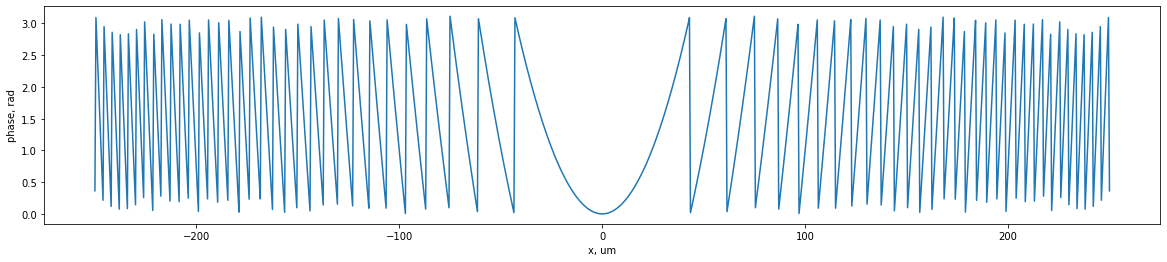

In [22]:
#example of 1D ideal planar lens
x = np.linspace(-0.25*mm,0.25*mm,1001)
phase_analyt0 = 2*np.pi/lam*(np.sqrt(x**2+f**2)-f)
phase_analyt = np.remainder(phase_analyt0,np.pi)

#plotting the phase dependence
plt.plot(x, phase_analyt)
plt.xlabel('x, um')
plt.ylabel('phase, rad')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 4)

In [6]:
#generating 2D phase map for an ideal planar lens
x = np.linspace(-0.25*mm,0.25*mm,1001)
y = np.linspace(-0.25*mm,0.25*mm,1001)
phase = []

X,Y = np.meshgrid(x,y)
phaseMap = 180/np.pi*np.remainder(2*np.pi/lam*(np.sqrt(X**2+Y**2+f**2)-f),np.pi) #in degrees  

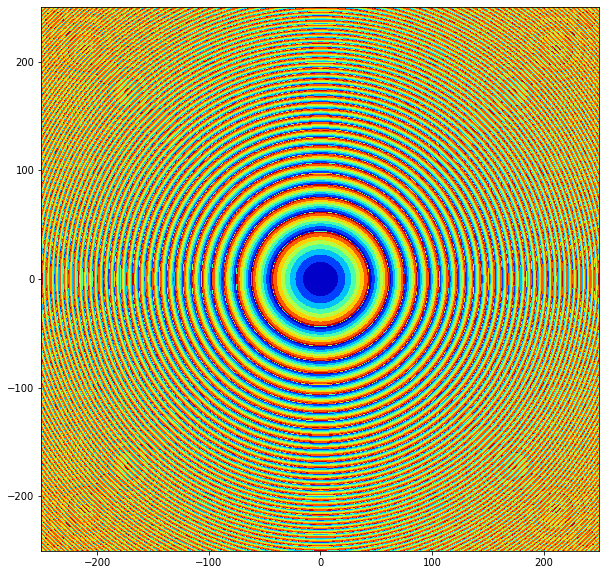

In [20]:
#2D surface plot
fig = plt.figure()
plt.contourf(X,Y,phaseMap, cmap=cm.jet)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)

In [8]:
#function to clean up cells
def clearCell(cell):
    cell.remove_polygons(lambda pts,layer,datatype:True)

In [9]:
#layer and datatype tags
ld_Si = {"layer":1, "datatype":1}

In [10]:
#creating a gdspy library
gdspy.current_library = gdspy.GdsLibrary()

In [11]:
#mapping phase to meta-atom radius
# phaseToRadiusMap = [[45+45*i,nm*(50+10*i)]for i in range(8)]
phaseToRadiusMap = [[45, 120*nm], [90, 115*nm], [135,105*nm], [180,100*nm], [225, 95*nm], [270, 135*nm], [315, 75*nm]]
phaseToRadiusMap

[[45, 0.12],
 [90, 0.115],
 [135, 0.105],
 [180, 0.1],
 [225, 0.095],
 [270, 0.135],
 [315, 0.075]]

In [12]:
def phaseToDiskRadius(phase, phaseToRadiusMap):
    for phaseMax in phaseToRadiusMap:
        if phase<=phaseMax[0]:
            return phaseMax[1]

In [13]:
#function to generate spatial xy meshgrid
def spatialMapGenerator(periodX, periodY, phaseMap):
    spatialMap = [[[periodX*x, periodY*y] for x in range(len(phaseMap))] for y in range(len(phaseMap[0]))]
    return spatialMap

In [14]:
spatialMap = spatialMapGenerator(periodX, periodY, phaseMap)
# spatialMap

In [15]:
#function to generate a circle of radius 'r' at position 'center'
def phaseDiskPoly(phase, phaseToRadiusMap, center):
    r = phaseToDiskRadius(phase, phaseToRadiusMap)
    disk = gdspy.Round(center,r)
    return disk

In [16]:
#function to generate 2D map of circles (metasurface)
def metalensGenerator(phaseMap, phaseToRadiusMap, spatialMap):
    disks = []
    for x in range(len(phaseMap)):
        for y in range(len(phaseMap[0])):
            disks.append(phaseDiskPoly(phaseMap[x][y], phaseToRadiusMap, spatialMap[x][y]))
    return disks
        

In [17]:
metalens = metalensGenerator(phaseMap, phaseToRadiusMap, spatialMap)

In [18]:
Lens=gdspy.Cell("Lens-1")
Lens.add(metalens)

In [19]:
#writing gds file
gdspy.current_library = gdspy.GdsLibrary()
gdspy.current_library.add(Lens)
# gdspy.current_library.add(top)
# top.add(gdspy.CellReference(Lens))
# top.add(gdspy.CellReference(Lens, (2*mm,2*mm)))
gdspy.write_gds('Metasurface.gds')